In [18]:
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as si

%matplotlib inline
import numpy as np
from ezpadova import parsec
from gala.units import galactic
from pyia import GaiaData

In [2]:
Z = 10 ** (-2.2 + np.log10(0.0207))
iso = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="panstarrs1")
iso = iso.to_astropy_table()

Interrogating http://stev.oapd.inaf.it...


In [3]:
g = GaiaData("/Users/apricewhelan/projects/gd1-dr3/data/gd1-GaiaDR3-PS1DR2-joined.fits")

In [4]:
init_masks = at.Table.read("/Users/apricewhelan/projects/gd1-dr3/cache/init-masks.fits")
sky_track_data = at.Table.read('/Users/apricewhelan/projects/gd1-dr3/data/dr2/dr2-sky-track.fits')

(7.352905371428534, 1.352905371428534)

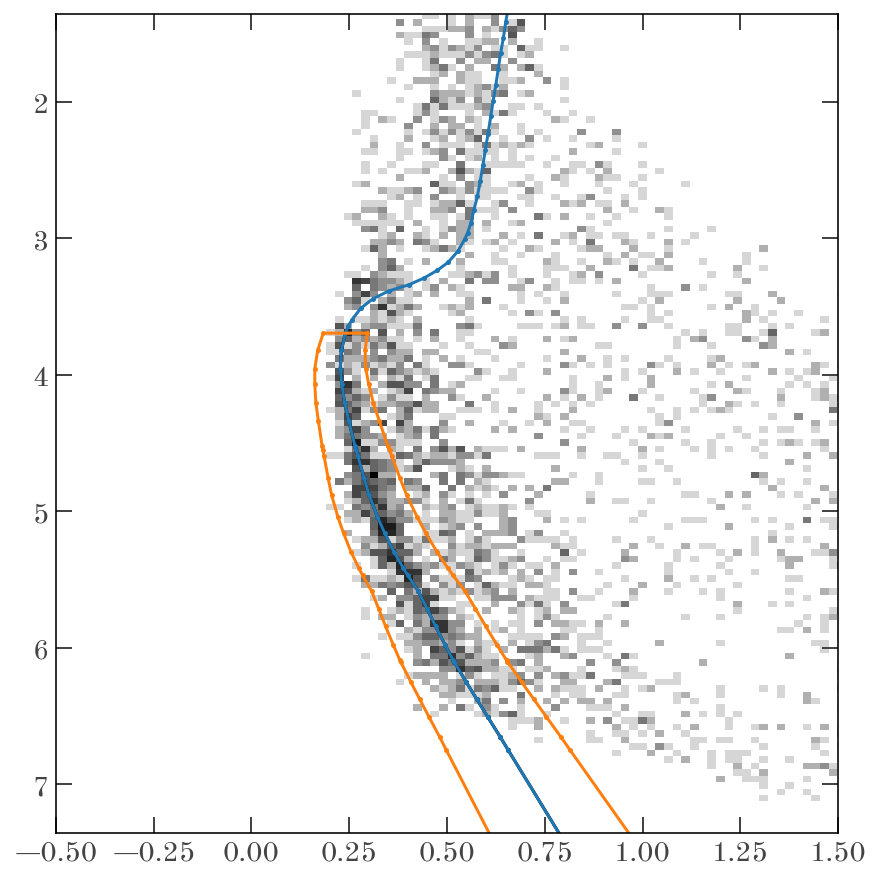

In [5]:
_mask = init_masks["sky_track"] & init_masks["pm_rough"]
DM = coord.Distance(8.5 * u.kpc).distmod.value
plt.hist2d(
    (g.g0 - g.i0)[_mask],
    g.g0[_mask] - DM,
    bins=256,
    norm=mpl.colors.LogNorm(),
    cmap="Greys",
)
poly_iso_mask = iso["stage"] <= 1
iso_mask = iso["stage"] <= 3

x, y = ((iso["gP1"] - iso["iP1"])[poly_iso_mask] + 0.02, iso["gP1"][poly_iso_mask])
iso_gi = (iso["gP1"] - iso["iP1"])[iso_mask] + 0.02
iso_g = iso["gP1"][iso_mask] + DM
plt.plot(x, y)
plt.plot(iso_gi, iso_g - DM)

w_poly = np.poly1d(np.polyfit([3.5, 5, 6.5], [0.05, 0.1, 0.15], deg=2))
X1 = np.stack((x - w_poly(y), y)).T
X2 = np.stack((x + w_poly(y), y)).T
X = np.vstack((X1, X2[::-1]))
cmd_path = mpl.path.Path(X)
plt.plot(X[:, 0], X[:, 1])

plt.xlim(-0.5, 1.5)
plt.ylim(22 - DM, 16 - DM)

In [6]:
c = g.get_skycoord(distance=False)
c_gd1 = c.transform_to(gc.GD1Koposov10())

(-10.0, 10.0)

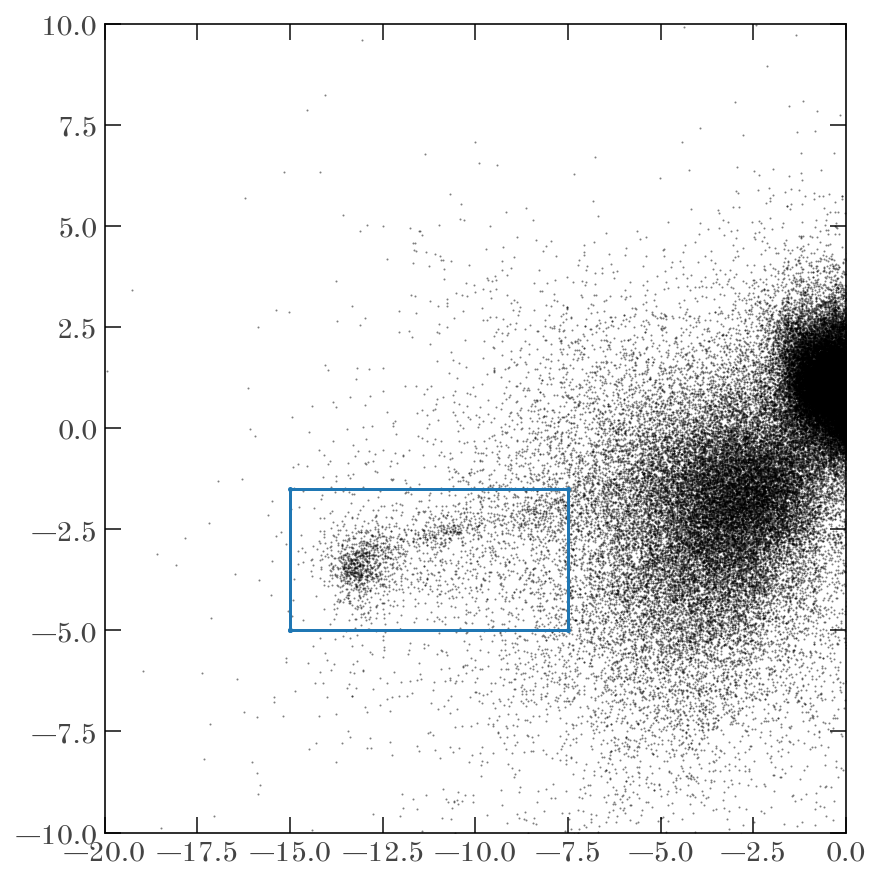

In [7]:
nodes = [[-15, -5.0], [-15, -1.5], [-7.5, -1.5], [-7.5, -5.0]]
nodes = np.concatenate((nodes, nodes[0:1]))
pm_path = mpl.path.Path(nodes)

plt.plot(
    c_gd1.pm_phi1_cosphi2.value[init_masks["sky_track"] & init_masks["cmd_ms"]],
    c_gd1.pm_phi2.value[init_masks["sky_track"] & init_masks["cmd_ms"]],
    ls="none",
    alpha=0.5,
    ms=2,
)
plt.plot(pm_path.vertices[:, 0], pm_path.vertices[:, 1])

plt.xlim(-20, 0)
plt.ylim(-10, 10)

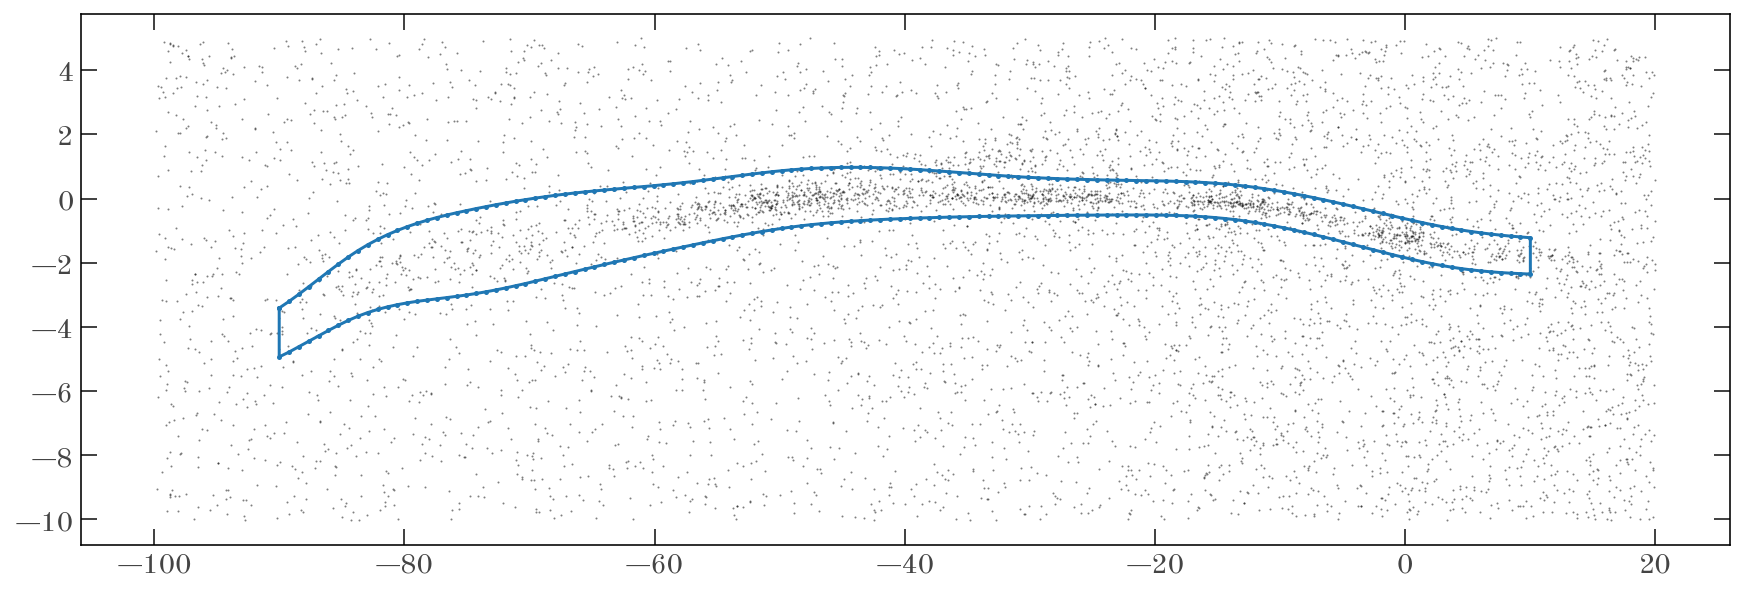

In [23]:
phi2_spl = si.InterpolatedUnivariateSpline(
    sky_track_data['phi1'],
    sky_track_data['phi2'], 
    k=3
)

ln_std_phi2_spl = si.InterpolatedUnivariateSpline(
    sky_track_data['phi1'],
    # sky_track_data['ln_std_phi2'], 
    convolve(sky_track_data['ln_std_phi2'], Gaussian1DKernel(1.), boundary='wrap'),
    k=3
)
phi1 = np.linspace(-90, 10, 128)
phi2 = phi2_spl(phi1)
std = np.exp(ln_std_phi2_spl(phi1))
sky_track_nodes1 = np.stack((phi1, phi2 + 3*std)).T
sky_track_nodes2 = np.stack((phi1, phi2 - 3*std)).T

X = np.vstack((sky_track_nodes1, sky_track_nodes2[::-1], sky_track_nodes1[0:1]))
sky_path = mpl.path.Path(X)

plt.figure(figsize=(12, 4))
_mask = init_masks['pm_rough'] & init_masks['cmd_ms']
plt.plot(c_gd1.phi1.degree[_mask], c_gd1.phi2.degree[_mask], ls='none', ms=2., alpha=0.5)
plt.plot(sky_path.vertices[:, 0], sky_path.vertices[:, 1])

In [24]:
cmd_mask = cmd_path.contains_points(np.stack((g.g0 - g.i0, g.g0 - DM)).T)
pm_mask = pm_path.contains_points(
    np.stack((c_gd1.pm_phi1_cosphi2.value, c_gd1.pm_phi2.value)).T
)
sky_mask = sky_path.contains_points(np.stack((c_gd1.phi1.degree, c_gd1.phi2.degree)).T)

In [32]:
gig_bins = (np.linspace(-0.5, 1.5, 181), np.linspace(14, 21.5, 181))
pm_bins = (np.arange(-20, 0 + 1e-3, 0.1), np.arange(-10, 10 + 1e-3, 0.1))
phi_bins = (np.arange(-100, 20 + 1e-3, 0.2), np.arange(-8, 5.0 + 1e-3, 0.2))


def plot_H(ax, xe, ye, H, norm='col', vmin_pcl=[0.5, 99.5], cmap="Greys"):
    if norm == 'col':
        H_norm = H.T / H.T.sum(axis=0)[None]
    elif norm == 'row':
        H_norm = H.T / H.T.sum(axis=1)[:, None]
    else:
        H_norm = H.T
    H_norm[~np.isfinite(H_norm)] = 0.0
    ax.pcolormesh(
        xe,
        ye,
        H_norm,
        vmin=np.nanpercentile(H_norm, vmin_pcl[0]),
        vmax=np.nanpercentile(H_norm, vmin_pcl[1]),
        cmap=cmap,
        zorder=1,
        rasterized=True
    )


fig, axes = plt.subplot_mosaic(
    # "AGBBB;CHDDD;EJFFF", figsize=(4 * 5, 4 * 3), layout="constrained"
    "AGBBB;CHDDD;EJFFF", figsize=(4 * 4, 4 * 2.4), layout="constrained"
)
cols = [["A", "C", "E"], ["G", "H", "J"], ["B", "D", "F"]]
for col in cols:
    for k in col[1:]:
        axes[k].sharex(axes[col[0]])
    # for k in col[:-1]:
    #     axes[k].tick_params(labelbottom=False)

cmaps = ["Greys", "Blues", "Purples"]

row_titles = [
    "All Gaia x PS1 data",
    "Matched Filter on Photometry",
    "& Selection in Gaia Proper Motions",
]
for i in range(3):
    axes[cols[2][i]].text(
        s=row_titles[i],
        x=18,
        y=-6.2,
        ha="right",
        va="top",
        fontsize=20,
        backgroundcolor=[1.0, 1.0, 1.0, 0.8],
        zorder=100,
    )

axes[cols[0][0]].plot(
    iso_gi,
    iso_g,
    marker="",
    color="tab:green",
    lw=1.5,
    alpha=0.9,
    zorder=101,
    label=r"$[{\rm M}/{\rm H}] = -2.2$"
    + "\n"
    + r"${\rm Age} = 12~{\rm Gyr}$"
    + "\n"
    + r"${\rm Dist.} = 8.5~{\rm kpc}$",
)
axes[cols[0][0]].legend(loc="upper left", fontsize=11, zorder=1000)

nodes_style_pre = dict(marker="", color="#333333", alpha=0.8, lw=2.0, zorder=100, linestyle='--')
nodes_style = dict(marker="", color="tab:red", alpha=0.9, lw=2.0, zorder=100)

# ----------------------------------------------------------------------------------
i = 0
cmap = "Purples"
ax = axes[cols[0][i]]
H, xe, ye = np.histogram2d((g.g0 - g.i0), g.g0, bins=gig_bins)
plot_H(ax, xe, ye, H, cmap=cmap, norm='row')

ax = axes[cols[1][i]]
H, xe, ye = np.histogram2d(
    c_gd1.pm_phi1_cosphi2.to_value(u.mas / u.yr),
    c_gd1.pm_phi2.to_value(u.mas / u.yr),
    bins=pm_bins,
)
plot_H(ax, xe, ye, H, cmap=cmap, norm='col')

ax = axes[cols[2][i]]
H, xe, ye = np.histogram2d(g.gd1_phi1, g.gd1_phi2, bins=phi_bins)
plot_H(ax, xe, ye, H, cmap=cmap, norm='col')

# ----------------------------------------------------------------------------------
i = 1
mask = cmd_mask
cmap = "Blues"
ax = axes[cols[0][i]]
H, xe, ye = np.histogram2d((g.g0 - g.i0)[mask], g.g0[mask], bins=gig_bins)
plot_H(ax, xe, ye, H, cmap=cmap, norm='row')
ax.plot(cmd_path.vertices[:, 0], cmd_path.vertices[:, 1] + DM, **nodes_style)

ax = axes[cols[1][i]]
H, xe, ye = np.histogram2d(
    c_gd1.pm_phi1_cosphi2.to_value(u.mas / u.yr)[mask],
    c_gd1.pm_phi2.to_value(u.mas / u.yr)[mask],
    bins=pm_bins,
)
plot_H(ax, xe, ye, H, cmap=cmap, norm='col')
ax.plot(pm_path.vertices[:, 0], pm_path.vertices[:, 1], **nodes_style_pre)

ax = axes[cols[2][i]]
H, xe, ye = np.histogram2d(g.gd1_phi1[mask], g.gd1_phi2[mask], bins=phi_bins)
H = convolve(H, Gaussian2DKernel(1.), boundary='extend')
plot_H(ax, xe, ye, H, cmap=cmap, norm='col')
ax.plot(sky_path.vertices[:, 0], sky_path.vertices[:, 1], **nodes_style_pre)

# ----------------------------------------------------------------------------------
i = 2
cmap = "Greys"
style = dict(ls="none", marker="o", ms=2.0, alpha=0.5, color="k", zorder=5)

ax = axes[cols[0][i]]
mask = sky_mask & pm_mask
# ax.plot((g.g0 - g.i0)[mask], g.g0[mask], **style)
H, xe, ye = np.histogram2d((g.g0 - g.i0)[mask], g.g0[mask], bins=gig_bins)
H = convolve(H, Gaussian2DKernel(1.), boundary='extend')
plot_H(ax, xe, ye, H, cmap=cmap, norm='row')
ax.plot(cmd_path.vertices[:, 0], cmd_path.vertices[:, 1] + DM, **nodes_style)

ax = axes[cols[1][i]]
mask = sky_mask & cmd_mask
# ax.plot(
#     c_gd1.pm_phi1_cosphi2.to_value(u.mas / u.yr)[mask],
#     c_gd1.pm_phi2.to_value(u.mas / u.yr)[mask],
#     **style
# )
H, xe, ye = np.histogram2d(
    c_gd1.pm_phi1_cosphi2.to_value(u.mas / u.yr)[mask],
    c_gd1.pm_phi2.to_value(u.mas / u.yr)[mask],
    bins=pm_bins,
)
plot_H(ax, xe, ye, H, cmap=cmap, norm='col')
ax.plot(pm_path.vertices[:, 0], pm_path.vertices[:, 1], **nodes_style)

ax = axes[cols[2][i]]
mask = cmd_mask & pm_mask
ax.plot(g.gd1_phi1[mask], g.gd1_phi2[mask], **style)
ax.plot(sky_path.vertices[:, 0], sky_path.vertices[:, 1], **nodes_style)


# Axis limits and labels:
for k in cols[0]:
    ax = axes[k]
    ax.set_xticks(np.arange(-1, 3 + 1e-3, 1))
    ax.set_xticks(np.arange(-1, 3 + 1e-3, 0.5), minor=True)
    ax.set_yticks(np.arange(10, 22 + 1e-3, 2))
    ax.set_yticks(np.arange(10, 22 + 1e-3, 1), minor=True)
    ax.set(
        xlim=(gig_bins[0].min(), gig_bins[0].max()),
        ylim=(gig_bins[1].max(), gig_bins[1].min()),
        xlabel="$(g-i)_0$ [mag]",
        ylabel="$g_0$ [mag]",
    )

for k in cols[1]:
    ax = axes[k]
    ax.set_xticks(np.arange(-20, 0 + 1e-3, 5))
    ax.set_xticks(np.arange(-20, 0 + 1e-3, 2.5), minor=True)
    ax.set_yticks(np.arange(-10, 10 + 1e-3, 5))
    ax.set_yticks(np.arange(-10, 10 + 1e-3, 2.5), minor=True)
    ax.set(
        xlim=(pm_bins[0].min(), pm_bins[0].max()),
        ylim=(pm_bins[1].min(), pm_bins[1].max()),
        xlabel=r"$\mu_{\phi_1, *}$ [${\rm mas}\,{\rm yr}^{-1}$]",
        ylabel=r"$\mu_{\phi_2}$ [${\rm mas}\,{\rm yr}^{-1}$]",
    )

for k in cols[2]:
    ax = axes[k]
    ax.set_xticks(np.arange(-100, 20 + 1e-3, 20))
    ax.set_xticks(np.arange(-100, 20 + 1e-3, 10), minor=True)
    ax.set_yticks(np.arange(-8, 5 + 1e-3, 2))
    ax.set_yticks(np.arange(-8, 5 + 1e-3, 1), minor=True)
    ax.set(
        xlim=(phi_bins[0].min(), phi_bins[0].max()),
        ylim=(phi_bins[1].min(), phi_bins[1].max()),
        xlabel=r"$\phi_1$ [deg]",
        ylabel=r"$\phi_2$ [deg]",
    )

fig.savefig("../tex/figures/gd1-filter-demo.pdf", dpi=250, bbox_inches="tight")

TypeError: Legend.__init__() got an unexpected keyword argument 'zorder'

/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
